In [258]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import preprocess_data, preprocess_gt_data
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
SEED = 0
EPS = 1e-6

TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"

In [260]:
data, all_gdps = load_data()

print(f"Data shape: {data.shape}")

X_train, y_train, X_valid, y_valid, country_train, country_valid,  X_means, X_stds, y_mean, y_std, min_date = preprocess_data(data=data, epsilon=EPS, train_pct=TRAIN_PROPORTION, mode=MODE, all_gdps=all_gdps, past_gdp_lags=PAST_GDPS)

if TEST_ALL_GT_DATA:
    gt_data = load_gt_data()
    X_valid, country_valid = preprocess_gt_data(gt_data, EPS, X_means, X_stds, min_date=min_date)

X_train[country_train == "Switzerland"].head()

Data shape: (550, 98)
Dropped 2 rows because of missing lagged GDP values
X_train shape : (486, 104)
X_valid shape : (55, 104)
y_train shape : (486,)
y_valid shape : (55,)


,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,Employment_average,GDP_lag_2,GDP_lag_1,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
5,-1.777432,0.536472,-2.460054,-1.711387,1.502876,-1.141483,-0.713845,-0.605311,1.645796,-0.215548,...,0.998491,0.270443,0.113832,-0.416598,-0.416598,-0.360505,-0.416598,2.415163,-0.416598,-0.413196
10,-1.728061,-0.101258,-2.460054,-1.711387,1.308748,-0.966122,-0.713845,-0.605311,1.969782,-1.280314,...,0.923869,0.113832,0.144335,-0.416598,-0.416598,-0.360505,-0.416598,2.415163,-0.416598,-0.413196
13,-1.679227,0.377039,-0.326428,-1.711387,0.888139,-1.433752,-0.901926,-0.605311,1.321810,-0.133643,...,0.140338,0.144335,-0.514904,-0.416598,-0.416598,-0.360505,-0.416598,2.415163,-0.416598,-0.413196
23,-1.630930,0.483328,-0.509311,-1.711387,1.244039,-1.199937,1.368479,-0.605311,1.904984,-0.952693,...,0.476137,-0.514904,-0.402222,-0.416598,-0.416598,-0.360505,-0.416598,2.415163,-0.416598,-0.413196
29,-1.581560,0.536472,-2.460054,-1.711387,0.920494,-1.141483,-0.713845,-0.605311,1.645796,-1.034598,...,0.811936,-0.402222,-0.211612,-0.416598,-0.416598,-0.360505,-0.416598,2.415163,-0.416598,-0.413196


In [261]:
y_train[country_train == "Switzerland"].head()

5     0.144335
10   -0.514904
13   -0.402222
23   -0.211612
29    0.158291
Name: GDP, dtype: float64

In [262]:
all_gdps[all_gdps["country"] == "Switzerland"].head()

,country,GDP,date
1278,Switzerland,53939.1,2010-06-01
1279,Switzerland,29038.9,1991-12-01
1280,Switzerland,28786.0,1991-09-01
1281,Switzerland,28599.8,1991-06-01
1282,Switzerland,28708.4,1991-03-01


In [263]:
models = {
    #'mlp': MLP(seed=SEED, n_models=5),
    #'kf': KalmanFilterMLP(seed=SEED),
    'ols': OLS(),
}

y_pred_train = {}
y_pred_valid = {}
for model in models:
    # Fit and predict on training and validation data
    if model == 'kf':
        models[model].fit(X_train, y_train, countries=country_train)
    else: 
        models[model].fit(X_train, y_train)

    y_pred_train[f'y_pred_{model}'] = models[model].predict(X_train, countries=country_train) if model == 'kf' else models[model].predict(X_train)
    y_pred_valid[f'y_pred_{model}'] = models[model].predict(X_valid, countries=country_valid) if model == 'kf' else models[model].predict(X_valid)

ols :


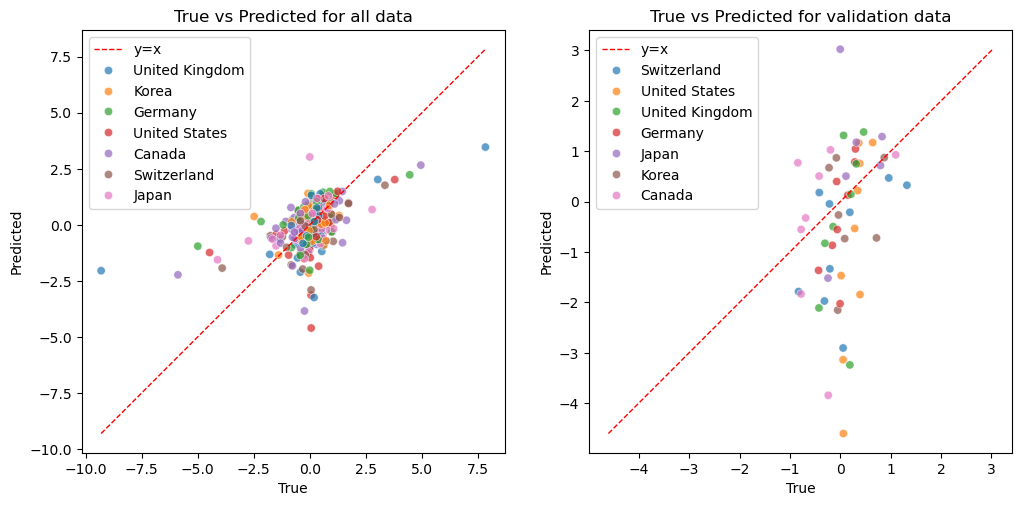

In [264]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame(dict({'date': X_valid['date'], 'country': country_valid, 'y_true': y_valid}, **y_pred_valid))
y_pred_train_country = pd.DataFrame(dict({'date': X_train['date'], 'country': country_train, 'y_true': y_train}, **y_pred_train))

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_true"] + [f'y_pred_{model}' for model in models],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(df, true_key="y_true", pred_key="y_pred"):
    plt.figure(figsize=(12, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(predictions[true_key]), np.min(predictions[pred_key])])
    line_max = np.max([np.max(predictions[true_key]), np.max(predictions[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(y_pred_valid_country[true_key]), np.min(y_pred_valid_country[pred_key])])
    line_max = np.max([np.max(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

if not TEST_ALL_GT_DATA:
    for model in models:
        print(f'{model} :')
        plot_predictions_against_true(predictions, true_key="y_true", pred_key=f"y_pred_{model}")

In [265]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data[filtered_data['Type'] == 'y_true']['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))

    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')

    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country, selected_country=dropdown)

# Calculate Mean Squared Error
for model in models:
    print(f"{model} : Training  ME: {mean_squared_error(y_train, y_pred_train[f'y_pred_{model}']):.4f}", end="")
    if not TEST_ALL_GT_DATA:
        print(f", Validation MSE: {mean_squared_error(y_valid, y_pred_valid[f'y_pred_{model}']):.4f}")
    else:
        print()

interactive(children=(Dropdown(description='Country:', options=('United Kingdom', 'Korea', 'Germany', 'United …

ols : Training  ME: 0.6426, Validation MSE: 2.1976


In [266]:
# OLD

import shap

PLOT_SHAP = False

if PLOT_SHAP:
    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 20))
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
